In [ ]:
pip install git+https://github.com/stefanradev93/bayesflow

Attention: Restart the runtime after installing bayesflow

# Import

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
from scipy import stats
import pickle

import tensorflow as tf


from tqdm import tqdm
from scipy.integrate import solve_ivp
import pickle

from sklearn.metrics import mean_squared_error
import time

In [3]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd

import bayesflow.diagnostics as diag
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

/usr/local/lib/python3.10/dist-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm






# **Generative Model Setup**

In [7]:
def ode_system(t, y, D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0):
  N,I,E,D = y
  Nt_dt = (N0 * (1+(I**p/(I0**p+I**p)))) - (kc * N * D) - (kt * N * D_ext) - gamma * N
  It_dt = (kt * N * D_ext) - (gamma_I * I)
  Et_dt = (1 * (I**p/(I0**p+I**p))) - (gamma * E)
  Dt_dt = (D0 * (I0**p/(I0**p+I**p))) - (kc*N*D) - (kt * N_ext * D) - (gamma * D)
  return [Nt_dt, It_dt, Et_dt, Dt_dt]

In [6]:
def Nonlinear_Solver(params, T, p = 2,
                     kc = 5.e-4,kt = 5.e-5,
                     gamma = 0.1,gamma_I = 0.5,
                     N0 = 500,I0 = 200, E0 = 1, D0 = 1000,
                     scale_I = 100, scale_N = 1000, scale_E = 0.25, scale_D = 3000):
  """Performs a forward simulation with LSODA method using solve_ivp for the Nonlinear ODE model given a random draw from the prior,"""
  # Extract parameters
  N_ext = params[0]
  D_ext = params[1]
  # Initial conditions
  initial_cond = [params[2],params[3],params[4],params[5]]
  # Simulate T+1 timesteps
  time = (0,T)
  solution = solve_ivp(ode_system,time, initial_cond, method='LSODA', args=(D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0),max_step=0.01)
  t = solution.t
  N_sol, I_sol, E_sol, D_sol = solution.y
  #return np.stack([N_sol/scale_N, I_sol/scale_I, E_sol/scale_E, D_sol/scale_D])
  return np.stack([N_sol, I_sol, E_sol, D_sol])

One Step Simulation

1. simulate data with restricted initial condition

In [ ]:
def prior_sample(Initial, Initial_Params = True):
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """

    N_ext = np.random.uniform(500,5500)
    D_ext = np.random.uniform(2500,3300)
    if Initial_Params:
      N_0 = 1000
      I_0 = 0
      E_0 = 0
      D_0 = 3000
    else:
      N_0 = Initial[0]
      I_0 = Initial[1]
      E_0 = Initial[2]
      D_0 = Initial[3]
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [ ]:
def simulate(N,T,N_time_steps):
  inital_conditions = np.zeros((4,))
  data = {}
  data['Prior'] = np.ndarray((0,6))
  data['next_step'] = np.ndarray((0,4))
  for i in range(N):
    prior = prior_sample(inital_conditions)
    data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
    TS = Nonlinear_Solver(prior[0],T)[:,-1].reshape((1,4))
    data['next_step'] = np.concatenate((data['next_step'],TS), axis=0)
  for i in tqdm(range(N_time_steps-1)):
    for p in range(N):
      inital_conditions = data['next_step'][p+i*N]
      prior = prior_sample(inital_conditions, Initial_Params = False)
      data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
      TS = Nonlinear_Solver(prior[0],T)[:,-1].reshape((1,4))
      data['next_step'] = np.concatenate((data['next_step'],TS), axis=0)
  return data

In [ ]:
def data_generator(batch_size, T):

  """
  This is for online training:

  Runs the forward model 'batch_size' times by first sampling fromt the prior
  theta ~ p(theta) and running x ~ p(x|theta).
  ----------

  Arguments:
  batch_size : int -- the number of samples to draw from the prior
  ----------

  Output:
  forward_dict : dict
      The expected outputs for a BayesFlow pipeline
  """

  # Generate data
  data = simulate(batch_size//32,T,32)
  forward_dict = {"prior_draws": data['Prior'], "sim_data": np.transpose(data['Time_Series'], axes=[0, 2, 1])}
  return forward_dict

In [ ]:
# Set generative function for online training
generative_model = partial(data_generator, T=10)

In [ ]:
# Simulating data for offline training
T = 10
data = simulate(70400//32,T,32)

In [ ]:
# save dictionary
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/One_Step_Simulated_Data.pkl', 'wb') as fp:
    pickle.dump(data, fp)

In [ ]:
# Read dictionary pkl file
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/One_Step_Simulated_Data.pkl', 'rb') as fp:
    d = pickle.load(fp)

2. Simulate data with random initial conditions

In [3]:
def prior_sample_dis():

    N_ext = np.random.uniform(400,6000)
    D_ext = np.random.uniform(0,3500)
    N_0 = np.random.uniform(400,6000)
    I_0 = np.random.uniform(0,1500)
    E_0 = np.random.uniform(0,10)
    D_0 = np.random.uniform(0,3500)
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [5]:
def simulate_dis(N,T):
  inital_conditions = np.zeros((4,))
  data = {}
  data['Prior'] = np.ndarray((0,6))
  data['next_step'] = np.ndarray((0,4))
  T_Ex = 0
  for i in tqdm(range(N)):
    prior = prior_sample_dis()
    data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
    s = time.time()
    TS = Nonlinear_Solver(prior[0],T)[:,-1].reshape((1,4))
    e = time.time()
    T_Ex += e-s
    data['next_step'] = np.concatenate((data['next_step'],TS), axis=0)
  print("Time_of_Execution = ", T_Ex)
  return data

In [9]:
s = time.time()
TS = Nonlinear_Solver([2.543e+03, 3.092e+03, 4.024e+03, 7.370e+02, 2.000e+00, 5.900e+01],10)
e = time.time()

In [11]:
(e-s)*6000

439.9094581604004

In [8]:
T = 10
data = simulate_dis(6400,T)

100%|██████████| 6400/6400 [04:18<00:00, 24.76it/s]

Time_of_Execution =  251.6010286808014


In [ ]:
T = 10
data = simulate_dis(70400,T)

100%|██████████| 70400/70400 [46:07<00:00, 25.44it/s]


In [ ]:
# save dictionary
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/One_Step_Simulated_Data_Dist_new.pkl', 'wb') as fp:
    pickle.dump(data, fp)

# Load Data

In [7]:
# Read dictionary pkl file


with open('/Training_Test_Sets/One_Step_Simulated_Data_Dist.pkl', 'rb') as fp:
    d = pickle.load(fp)

setting the train set

In [8]:
mX = [6000,3500,6000,1500,10,3500]
mX = [0.1*m+m for m in mX]
#mY = mX[2:]
mY = [1,4,600,1.7]
#normalized_dataY = np.divide(d['next_step'],mX[2:])
normalized_dataY = (d['next_step'])*mY
normalized_dataX = np.divide(d['Prior'],mX)

In [9]:
training_data = {}
valid_data = {}
training_data['prior_draws'] = normalized_dataX[3200:67200]
training_data['sim_data'] = normalized_dataY[3200:67200]
valid_data['prior_draws'] = np.concatenate((normalized_dataX[0:320],normalized_dataX[67200:70400]),axis = 0)
valid_data['sim_data'] = np.concatenate((normalized_dataY[0:320],normalized_dataY[67200:70400]), axis =0)

# Amortizer and Trainer

In [10]:
# No summary net, mock
summary_net = lambda x, **kwargs: x

# Robust inference with a Student-T latent
latent_dist_p = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*6, scale=tf.linalg.LinearOperatorDiag([1.]*6))
latent_dist_l = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*4, scale=tf.linalg.LinearOperatorDiag([1.]*4))


coupling_settings = {
    'affine': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    },
    'spline': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    }
}

# Inference networks
inference_net_p = InvertibleNetwork(
    num_params=6,
    num_coupling_layers=6,
    coupling_design='interleaved',
    coupling_settings=coupling_settings
)

inference_net_l = InvertibleNetwork(
    num_params=4,
    num_coupling_layers=8,
    coupling_design='interleaved',
    coupling_settings=coupling_settings,
)

# Amortizers
amortized_posterior = AmortizedPosterior(
    inference_net=inference_net_p,
    summary_net=summary_net,
    latent_dist=latent_dist_p
)

amortized_likelihood = AmortizedLikelihood(
    surrogate_net=inference_net_l,
    latent_dist=latent_dist_l
)

amortizer = AmortizedPosteriorLikelihood(
    amortized_posterior,
    amortized_likelihood
)

In [11]:
def _config_posterior(forward_dict):
    """Helper function for posterior configuration."""

    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["direct_conditions"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict


def _config_likelihood(forward_dict):
    """Helper function for likelihood configuration."""

    input_dict = {}
    input_dict["conditions"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["observables"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict

def configurator(forward_dict, mode = "joint"):
    """Configures simulator outputs for use in BayesFlow training."""

    # Case only posterior configuration
    if mode == "posterior":
        input_dict = _config_posterior(forward_dict)

    # Case only plikelihood configuration
    elif mode == "likelihood":
        input_dict = _config_likelihood(forward_dict)

    # Case posterior and likelihood configuration (i.e., joint inference)
    elif mode == "joint":
        input_dict = {}
        input_dict["posterior_inputs"] = _config_posterior(forward_dict)
        input_dict["likelihood_inputs"] = _config_likelihood(forward_dict)

    # Throw otherwise
    else:
        raise NotImplementedError('For now, only a choice between ["posterior", "likelihood", "joint"] is available!')
    return input_dict

In [12]:
initial_learning_rate = 0.005

trainer = Trainer(
    amortizer=amortizer,
    default_lr=initial_learning_rate,
    checkpoint_path= "/content/drive/MyDrive/Team_Project/Checkpoint/JANA_Next/",
    configurator=configurator,
)

# decay_steps = 500
num_sim = training_data['sim_data'].shape[0]
batch_size = 64
## calculate number of epochs needed to get desired number of iterations
# epochs = decay_steps // (num_sim // batch_size)


INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from /content/drive/MyDrive/Team_Project/Checkpoint/JANA_Next/history_75.pkl.
INFO:root:Networks loaded from /content/drive/MyDrive/Team_Project/Checkpoint/JANA_Next/ckpt-75


Training

In [15]:
losses = trainer.train_offline(training_data, epochs=50, batch_size=batch_size)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/1000 [00:00<?, ?it/s]

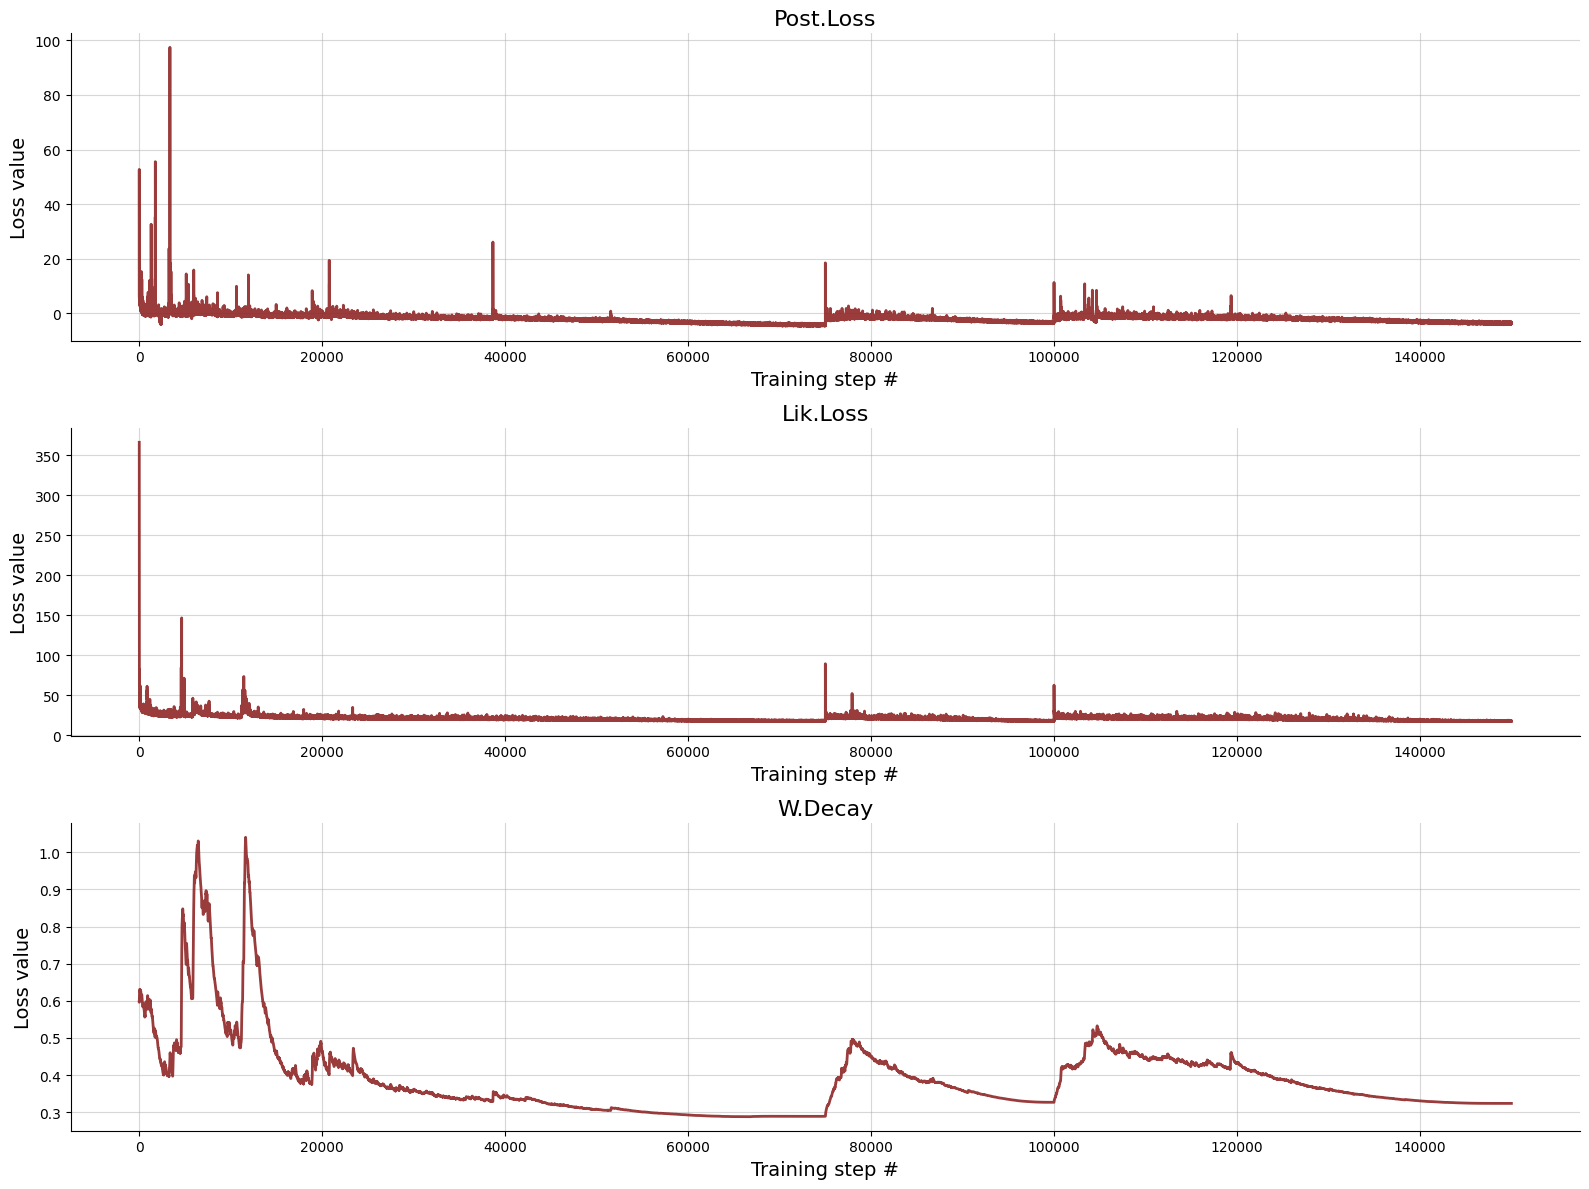

In [16]:
fig = diag.plot_losses(losses)

Validation

In [17]:
test_dict = {}
test_dict['conditions'] = tf.convert_to_tensor(
    valid_data['prior_draws'], dtype=float, dtype_hint=None, name=None
)
test_dict['training'] = 'False'

In [18]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1, to_numpy = True )
x_sim_s = np.divide(np.squeeze(x_sim_s),mY)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


# Test

In [19]:
N_ext = 3000
D_ext = 2700
Initial = [N_ext, D_ext, 1000 , 3, 2, 450]

In [20]:
def prior_sample_test(Initial):
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """

    N_ext = Initial[0]
    D_ext = Initial[1]
    N_0 = Initial[2]
    I_0 = Initial[3]
    E_0 = Initial[4]
    D_0 = Initial[5]
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [21]:
def ode_system(t, y, D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0):
  N,I,E,D = y
  Nt_dt = (N0 * (1+(I**p/(I0**p+I**p)))) - (kc * N * D) - (kt * N * D_ext) - gamma * N
  It_dt = (kt * N * D_ext) - (gamma_I * I)
  Et_dt = (1 * (I**p/(I0**p+I**p))) - (gamma * E)
  Dt_dt = (D0 * (I0**p/(I0**p+I**p))) - (kc*N*D) - (kt * N_ext * D) - (gamma * D)
  return [Nt_dt, It_dt, Et_dt, Dt_dt]

In [22]:
def Nonlinear_Solver(params, T, p = 2,
                     kc = 5.e-4,kt = 5.e-5,
                     gamma = 0.1,gamma_I = 0.5,
                     N0 = 500,I0 = 200, E0 = 1, D0 = 1000,
                     scale_I = 100, scale_N = 1000, scale_E = 0.25, scale_D = 3000):
  """Performs a forward simulation with LSODA method using solve_ivp for the Nonlinear ODE model given a random draw from the prior,"""
  # Extract parameters
  N_ext = params[0]
  D_ext = params[1]
  # Initial conditions
  initial_cond = [params[2],params[3],params[4],params[5]]
  # Simulate T+1 timesteps
  time = (0,T)
  solution = solve_ivp(ode_system,time, initial_cond, method='LSODA', args=(D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0),max_step=0.01)
  t = solution.t
  N_sol, I_sol, E_sol, D_sol = solution.y
  #return np.stack([N_sol/scale_N, I_sol/scale_I, E_sol/scale_E, D_sol/scale_D])
  return np.stack([N_sol, I_sol, E_sol, D_sol])

In [23]:
def test_1(N,N_time_steps):
  data = {}
  data['Prior'] = np.ndarray((0,6))
  data['next_step'] = np.zeros((N,4,1))
  inital_conditions = Initial
  for i in range(N):
    prior = prior_sample_test(inital_conditions)
    data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
  data['next_step'][:N,:,0] = data['Prior'][:,2:]
  for i in range(N_time_steps-1):
    if N==1 :
      inital_conditions = np.concatenate((np.array([N_ext,D_ext]),data['next_step'][0,:,i]), axis = -1)
      prior = prior_sample_test(inital_conditions)
      test_dict = {}
      test_dict['conditions'] = tf.convert_to_tensor(
          np.divide(prior,mX), dtype=float, dtype_hint=None, name=None
      )
      test_dict['training'] = 'False'
      pred = amortizer.sample_data(test_dict, n_samples=100, to_numpy = True )

      pred = np.nanmean(pred,axis = 0)

      pred = np.divide(pred,mY)
      #pred = np.squeeze(np.mean(x_sim_s,axis = 1))
      data['next_step'] = np.concatenate((data['next_step'],pred.reshape(N,4,1)), axis=-1)

    else:
      print("N > 1")
  return data

In [24]:
T = 6

Test_Data = test_1(1,T)
Test_Data['Real_Time_Series'] = Nonlinear_Solver(prior_sample_test(Initial)[0],T*10)

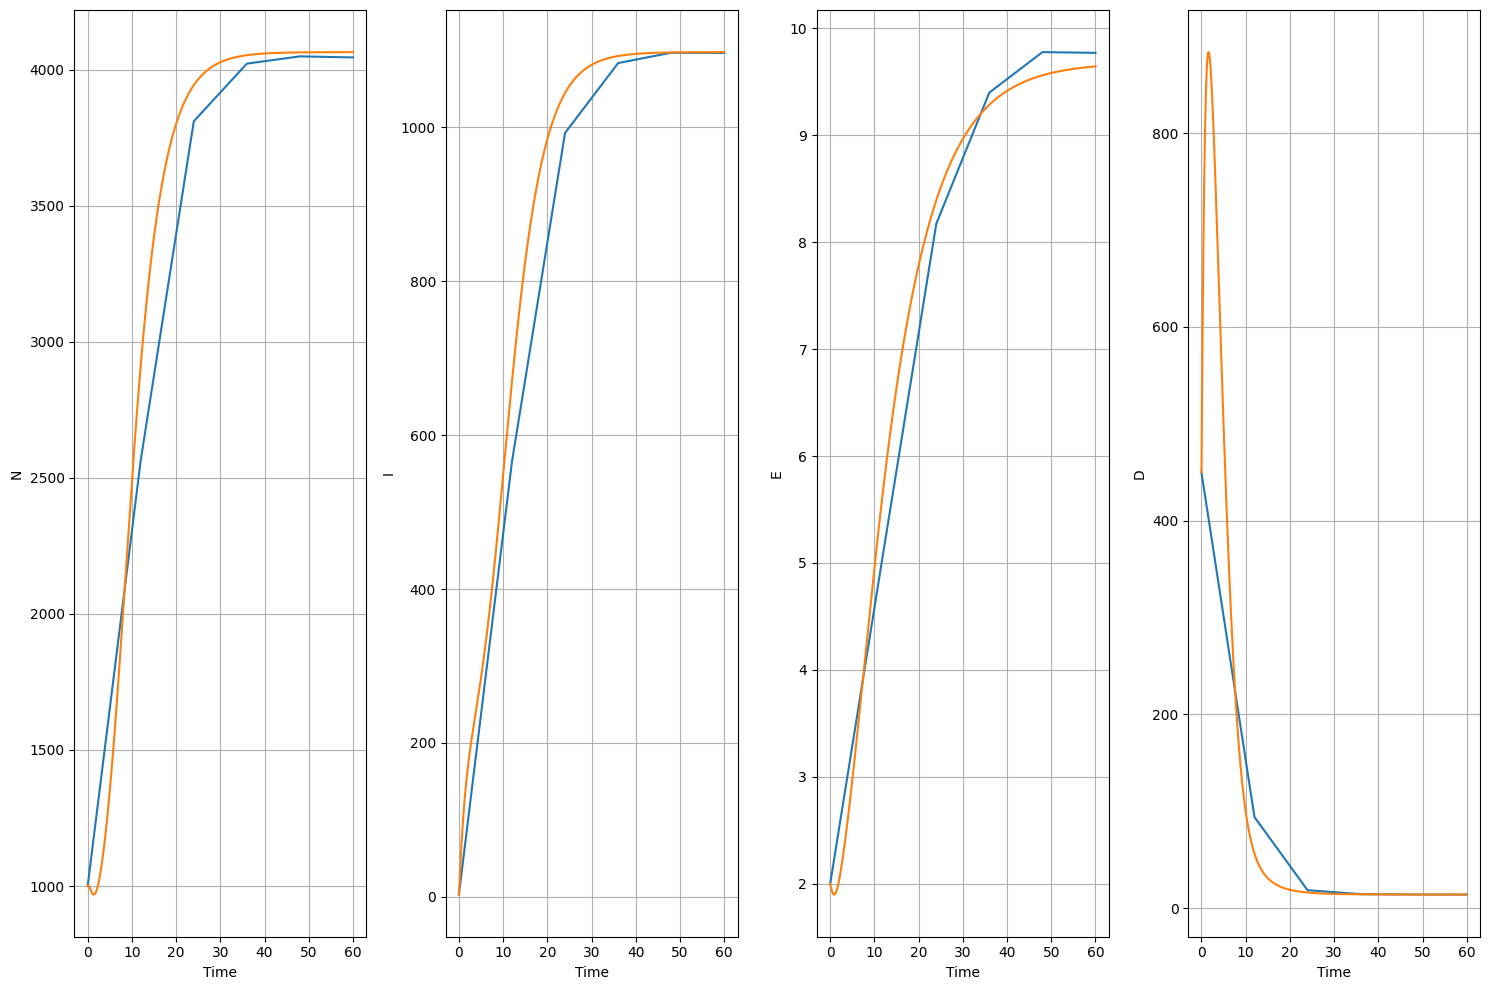

In [25]:
x1 = np.linspace(0, T*10, num=T)
x2 = np.linspace(0, T*10, num=Test_Data['Real_Time_Series'].shape[1])
#predicted = np.concatenate((prior_sample_test(Initial)[:,2:],x_sim_s),axis=0)
predicted = Test_Data['next_step'][0]
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
ax = ax.flat

for i in range(4):
    ax[i].plot(x1,predicted[i,:], label = "Predicted")
    ax[i].plot(x2,Test_Data['Real_Time_Series'][i], label = "Simulated")
    ax[i].set_xlabel("Time")
    if i == 0:
      ax[i].set_ylabel("N")
    elif i == 1:
      ax[i].set_ylabel("I")
    elif i == 2:
      ax[i].set_ylabel("E")
    elif i == 3:
      ax[i].set_ylabel("D")
    ax[i].grid(True)

plt.tight_layout()
plt.show()

# Toy Example

In [26]:
def prior_sample(Initial, Initial_Params = True):
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """

    N_ext = np.random.uniform(500,5500)
    D_ext = np.random.uniform(2500,3300)
    if Initial_Params:
      #N_ext = np.random.uniform(500,5500)
      #D_ext = np.random.uniform(2500,3300)
      N_0 = np.random.uniform(380,4500)
      print("N_0 = ", N_0)

      I_0 = np.random.uniform(0,1500)
      print("I_0 = ", I_0)

      E_0 = np.random.uniform(0,10)
      print("E_0 = ", E_0)

      D_0 = np.random.uniform(10,3000)
      print("D_0 = ", D_0)

    else:
      N_0 = Initial[0]
      I_0 = Initial[1]
      E_0 = Initial[2]
      D_0 = Initial[3]
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [27]:
def Setting_Params(Prev_Step_out):
  new_prior = np.zeros((6,Prev_Step_out.shape[1]))
  for i in range(Prev_Step_out.shape[1]):
    if i == 0:
      new_prior[0][i] = Prev_Step_out[0][i+1]
      new_prior[1][i] = Prev_Step_out[3][i+1]
    elif i == Prev_Step_out.shape[1]-1:
      new_prior[0][i] = Prev_Step_out[0][i-1]
      new_prior[1][i] = Prev_Step_out[3][i-1]
    else:
      new_prior[0][i] = 0.5*Prev_Step_out[0][i-1] + 0.5*Prev_Step_out[0][i+1]
      new_prior[1][i] = 0.5*Prev_Step_out[3][i-1] + 0.5*Prev_Step_out[3][i+1]
    #print(new_prior[0])
    #print(new_prior[1])
    new_prior[2][i] = Prev_Step_out[0][i]
    new_prior[3][i] = Prev_Step_out[1][i]
    new_prior[4][i] = Prev_Step_out[2][i]
    new_prior[5][i] = Prev_Step_out[3][i]
  return new_prior

In [28]:
N_Cells = 10
Initial_Cells = {}
Initial_Cells['Prior'] = np.ndarray((0,6))
inital_conditions = np.zeros((4,))
for i in range(N_Cells):
  prior = prior_sample(inital_conditions)
  Initial_Cells['Prior'] = np.concatenate((Initial_Cells['Prior'], prior), axis=0)

A = np.zeros((10,6))
#Cell number  0
A[0][2] =  1835.1294454248948
A[0][3] =  329.70985181343406
A[0][4] =  9.91481515640452
A[0][5] =  2235.3864692759657
#Cell number  1
A[1][2] =  1275.558664847953
A[1][3] =  593.6565675693729
A[1][4] =  9.363441833518873
A[1][5] =  1125.4568341552365
#Cell number  2
A[2][2] =  2853.422549520553
A[2][3] =  99.36691922468982
A[2][4] =  9.021156118306058
A[2][5] =  219.14507736065477
#Cell number  3
A[3][2] =  498.28026684835845
A[3][3] =  1492.0329168951134
A[3][4] =  0.3508781117439963
A[3][5] =  218.87083599924608
#Cell number  4
A[4][2] =  4440.854907207302
A[4][3] =  1311.865245045852
A[4][4] =  6.944665497484165
A[4][5] =  2724.100337493131
#Cell number  5
A[5][2]=  3529.357777465493
A[5][3] =  865.3996195496832
A[5][4] =  3.1816089300273243
A[5][5] =  967.8782884068388
#Cell number  6
A[6][2] =  4125.005755487573
A[6][3] =  657.6200688380189
A[6][4] =  6.240878607687883
A[6][5] =  2410.4797123670214
#Cell number  7
A[7][2] =  1172.1556474445902
A[7][3] =  870.780363136085
A[7][4] =  4.963713400462191
A[7][5] =  2951.3805392422464
#Cell number  8
A[8][2] =  3152.0123248960526
A[8][3] =  676.3365573041848
A[8][4] =  4.223105920868997
A[8][5] =  482.5191013735446
#Cell number  9
A[9][2] =  1975.866558058985
A[9][3] =  342.02802578614626
A[9][4] =  0.3588372370364801
A[9][5] =  1026.691089760975

Initial_Cells['Prior'] = A

N_0 =  638.8243651803992
I_0 =  1135.8952653056097
E_0 =  3.9765007591965262
D_0 =  712.0044185001125
N_0 =  2412.4879836573336
I_0 =  403.3773635030205
E_0 =  2.4257215096300855
D_0 =  1161.797322995697
N_0 =  1877.223064533184
I_0 =  334.0517251774767
E_0 =  5.310396762152423
D_0 =  648.8377766536416
N_0 =  3378.454957933185
I_0 =  856.1913132338684
E_0 =  9.633034269774795
D_0 =  1078.2331964505304
N_0 =  733.2428622822995
I_0 =  905.7454528755187
E_0 =  0.7995520854797666
D_0 =  2831.1409687113605
N_0 =  2772.8364784729697
I_0 =  204.65751467879866
E_0 =  8.4058436487585
D_0 =  2428.2271096563577
N_0 =  1045.7774592028823
I_0 =  386.93885364740595
E_0 =  8.035973867266254
D_0 =  1130.8671079486467
N_0 =  4130.799212012589
I_0 =  42.397714649197894
E_0 =  3.8123797934833856
D_0 =  525.9956765744347
N_0 =  471.84268207303546
I_0 =  286.9931053199593
E_0 =  7.993942938142869
D_0 =  820.3889867883635
N_0 =  891.9019789874089
I_0 =  912.8043177701928
E_0 =  7.8336749814057525
D_0 =  201

In [29]:
steps = 50
Changes_In_Time_Pred = np.zeros((10,6,steps))
Changes_In_Time_Sim = np.zeros((10,6,steps))
test_dict = {}
test_dict['training'] = 'False'
Cells = Initial_Cells["Prior"][:,2:]
Cells_sim = Initial_Cells["Prior"][:,2:]

Test = {}
for i in tqdm(range(steps)):
  Cells = np.transpose(Cells)
  Cells_sim = np.transpose(Cells_sim)

  next_step_prior = Setting_Params(Cells)
  Cells = np.transpose(next_step_prior)
  print(Cells.shape)

  next_step_prior = Setting_Params(Cells_sim)
  Cells_sim = np.transpose(next_step_prior)
  print(Cells_sim.shape)

  Changes_In_Time_Pred[:,:,i] = Cells
  Changes_In_Time_Sim[:,:,i] = Cells_sim
  test_dict['conditions'] =  tf.convert_to_tensor(
      np.divide(Cells,mX), dtype=float, dtype_hint=None, name=None
      )
  x_pred = amortizer.sample_data(test_dict, n_samples=100, to_numpy = True )
  x_pred = np.divide(np.squeeze(np.nanmean(x_pred,axis = 1)),mY)
  #x_pred_t = np.transpose(x_pred)
  Cells = x_pred

  x_sim = np.zeros((10,4))
  for p in range(N_Cells):
    x_sim[p] = Nonlinear_Solver(Cells_sim[p],10)[:,-1]
  #x_sim_t = np.transpose(x_sim)
  Cells_sim = x_sim

  0%|          | 0/50 [00:00<?, ?it/s]

(10, 6)
(10, 6)


  2%|▏         | 1/50 [00:01<00:56,  1.15s/it]

(10, 6)
(10, 6)


  4%|▍         | 2/50 [00:02<00:54,  1.14s/it]

(10, 6)
(10, 6)


  6%|▌         | 3/50 [00:03<00:52,  1.11s/it]

(10, 6)
(10, 6)


  8%|▊         | 4/50 [00:04<00:50,  1.09s/it]

(10, 6)
(10, 6)


 10%|█         | 5/50 [00:05<00:43,  1.03it/s]

(10, 6)
(10, 6)


 12%|█▏        | 6/50 [00:05<00:39,  1.12it/s]

(10, 6)
(10, 6)


 14%|█▍        | 7/50 [00:06<00:35,  1.20it/s]

(10, 6)
(10, 6)


 16%|█▌        | 8/50 [00:07<00:33,  1.25it/s]

(10, 6)
(10, 6)


 18%|█▊        | 9/50 [00:08<00:32,  1.27it/s]

(10, 6)
(10, 6)


 20%|██        | 10/50 [00:08<00:30,  1.30it/s]

(10, 6)
(10, 6)


 22%|██▏       | 11/50 [00:09<00:29,  1.33it/s]

(10, 6)
(10, 6)


 24%|██▍       | 12/50 [00:10<00:28,  1.32it/s]

(10, 6)
(10, 6)


 26%|██▌       | 13/50 [00:11<00:27,  1.33it/s]

(10, 6)
(10, 6)


 28%|██▊       | 14/50 [00:11<00:27,  1.32it/s]

(10, 6)
(10, 6)


 30%|███       | 15/50 [00:12<00:25,  1.35it/s]

(10, 6)
(10, 6)


 32%|███▏      | 16/50 [00:13<00:24,  1.37it/s]

(10, 6)
(10, 6)


 34%|███▍      | 17/50 [00:13<00:24,  1.36it/s]

(10, 6)
(10, 6)


 36%|███▌      | 18/50 [00:14<00:25,  1.25it/s]

(10, 6)
(10, 6)


 38%|███▊      | 19/50 [00:15<00:26,  1.16it/s]

(10, 6)
(10, 6)


 40%|████      | 20/50 [00:16<00:27,  1.10it/s]

(10, 6)
(10, 6)


 42%|████▏     | 21/50 [00:17<00:26,  1.07it/s]

(10, 6)
(10, 6)


 44%|████▍     | 22/50 [00:18<00:26,  1.04it/s]

(10, 6)
(10, 6)


 46%|████▌     | 23/50 [00:19<00:24,  1.08it/s]

(10, 6)
(10, 6)


 48%|████▊     | 24/50 [00:20<00:22,  1.15it/s]

(10, 6)
(10, 6)


 50%|█████     | 25/50 [00:21<00:20,  1.21it/s]

(10, 6)
(10, 6)


 52%|█████▏    | 26/50 [00:21<00:18,  1.27it/s]

(10, 6)
(10, 6)


 54%|█████▍    | 27/50 [00:22<00:17,  1.31it/s]

(10, 6)
(10, 6)


 56%|█████▌    | 28/50 [00:23<00:16,  1.34it/s]

(10, 6)
(10, 6)


 58%|█████▊    | 29/50 [00:24<00:15,  1.36it/s]

(10, 6)
(10, 6)


 60%|██████    | 30/50 [00:24<00:14,  1.39it/s]

(10, 6)
(10, 6)


 62%|██████▏   | 31/50 [00:25<00:13,  1.39it/s]

(10, 6)
(10, 6)


 64%|██████▍   | 32/50 [00:26<00:12,  1.41it/s]

(10, 6)
(10, 6)


 66%|██████▌   | 33/50 [00:26<00:11,  1.43it/s]

(10, 6)
(10, 6)


 68%|██████▊   | 34/50 [00:27<00:11,  1.43it/s]

(10, 6)
(10, 6)


 70%|███████   | 35/50 [00:28<00:10,  1.44it/s]

(10, 6)
(10, 6)


 72%|███████▏  | 36/50 [00:28<00:09,  1.43it/s]

(10, 6)
(10, 6)


 74%|███████▍  | 37/50 [00:29<00:10,  1.28it/s]

(10, 6)
(10, 6)


 76%|███████▌  | 38/50 [00:31<00:10,  1.14it/s]

(10, 6)
(10, 6)


 78%|███████▊  | 39/50 [00:32<00:10,  1.08it/s]

(10, 6)
(10, 6)


 80%|████████  | 40/50 [00:33<00:09,  1.06it/s]

(10, 6)
(10, 6)


 82%|████████▏ | 41/50 [00:34<00:08,  1.02it/s]

(10, 6)
(10, 6)


 84%|████████▍ | 42/50 [00:34<00:07,  1.10it/s]

(10, 6)
(10, 6)


 86%|████████▌ | 43/50 [00:35<00:05,  1.18it/s]

(10, 6)
(10, 6)


 88%|████████▊ | 44/50 [00:36<00:04,  1.24it/s]

(10, 6)
(10, 6)


 90%|█████████ | 45/50 [00:37<00:03,  1.27it/s]

(10, 6)
(10, 6)


 92%|█████████▏| 46/50 [00:37<00:03,  1.30it/s]

(10, 6)
(10, 6)


 94%|█████████▍| 47/50 [00:38<00:02,  1.35it/s]

(10, 6)
(10, 6)


 96%|█████████▌| 48/50 [00:39<00:01,  1.39it/s]

(10, 6)
(10, 6)


 98%|█████████▊| 49/50 [00:39<00:00,  1.39it/s]

(10, 6)
(10, 6)


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


# Plots for toy example

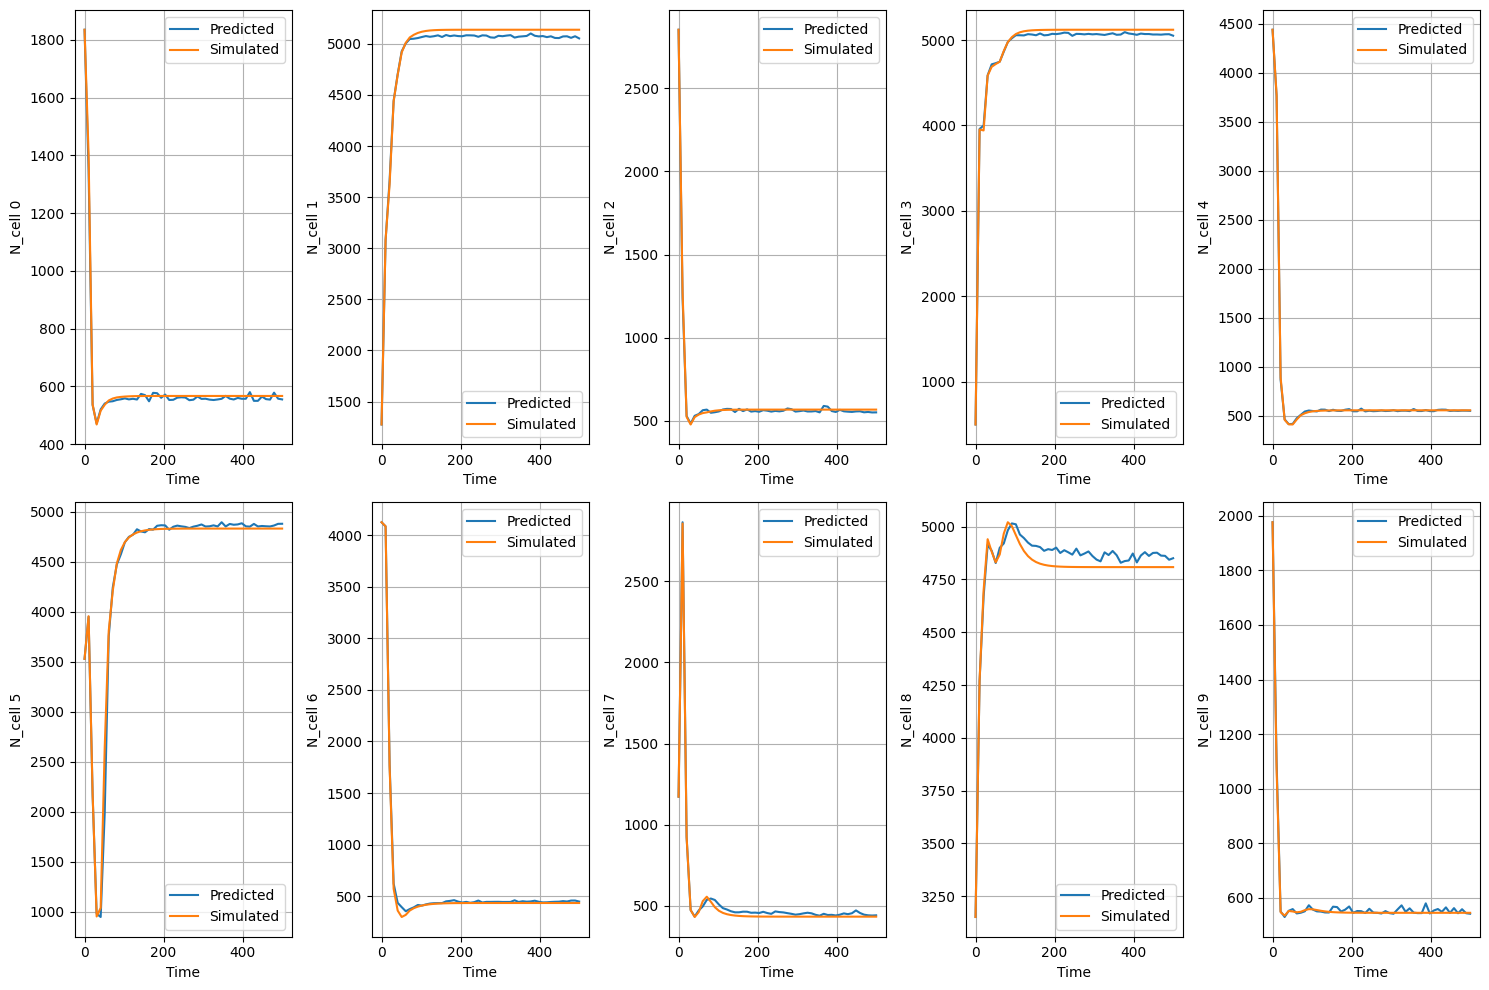

In [30]:
#Plots for N

x1 = np.linspace(0, 50*10)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][2] , label = "Predicted")
    ax[i].plot(x1,sim[i][2], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"N_cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

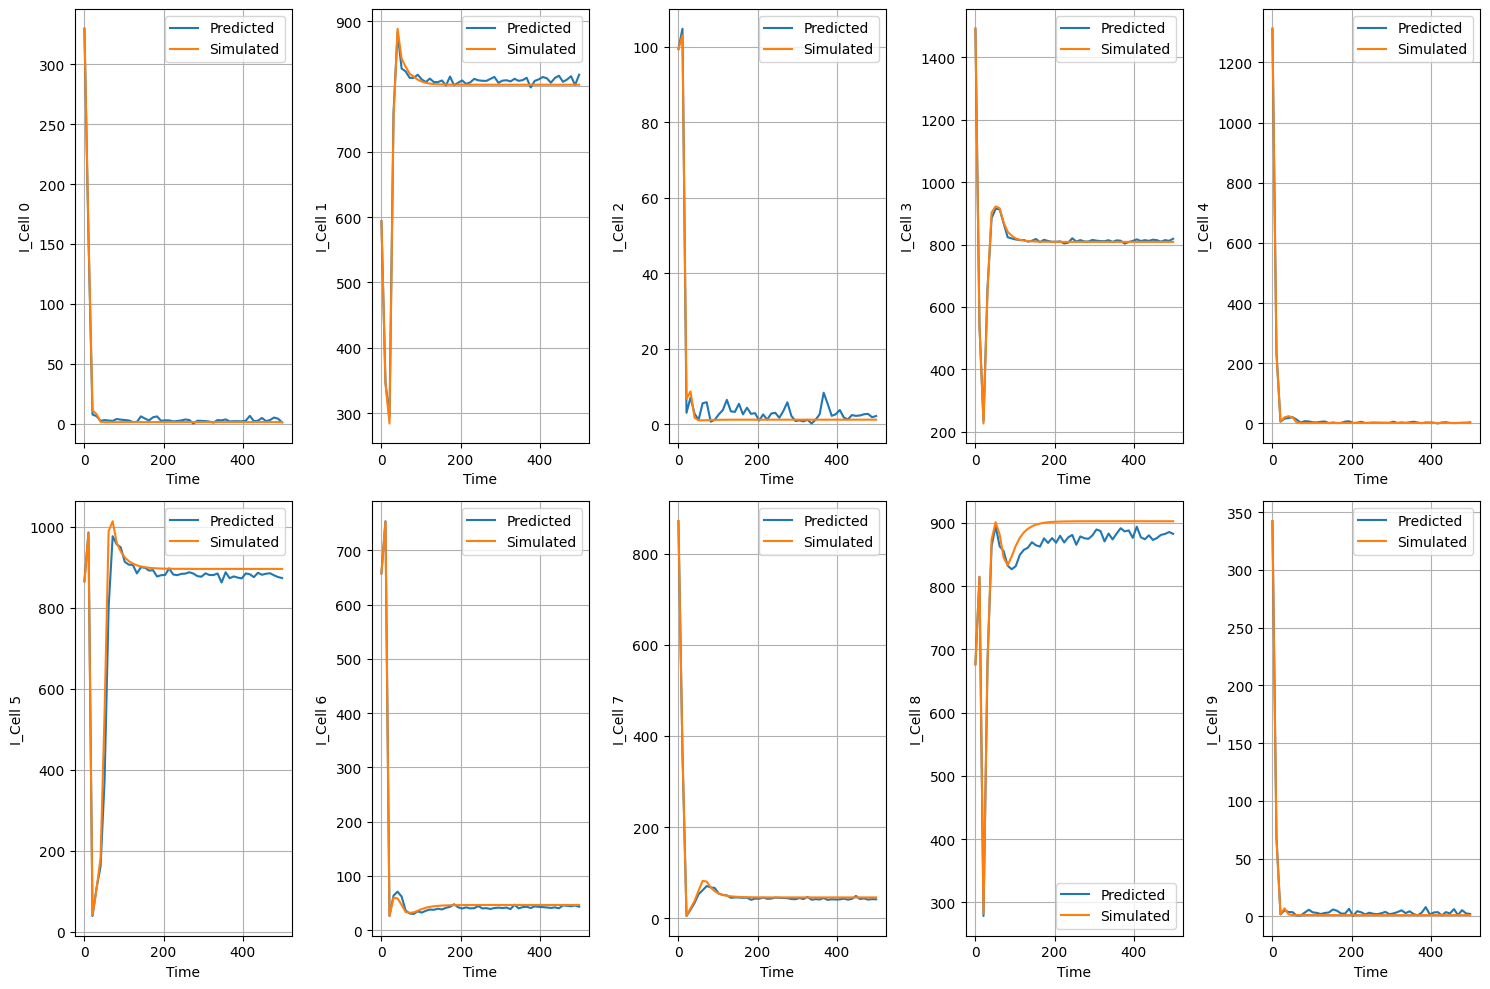

In [31]:
#Plots for I

x1 = np.linspace(0, 50*10)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][3] , label = "Predicted")
    ax[i].plot(x1,sim[i][3], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"I_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

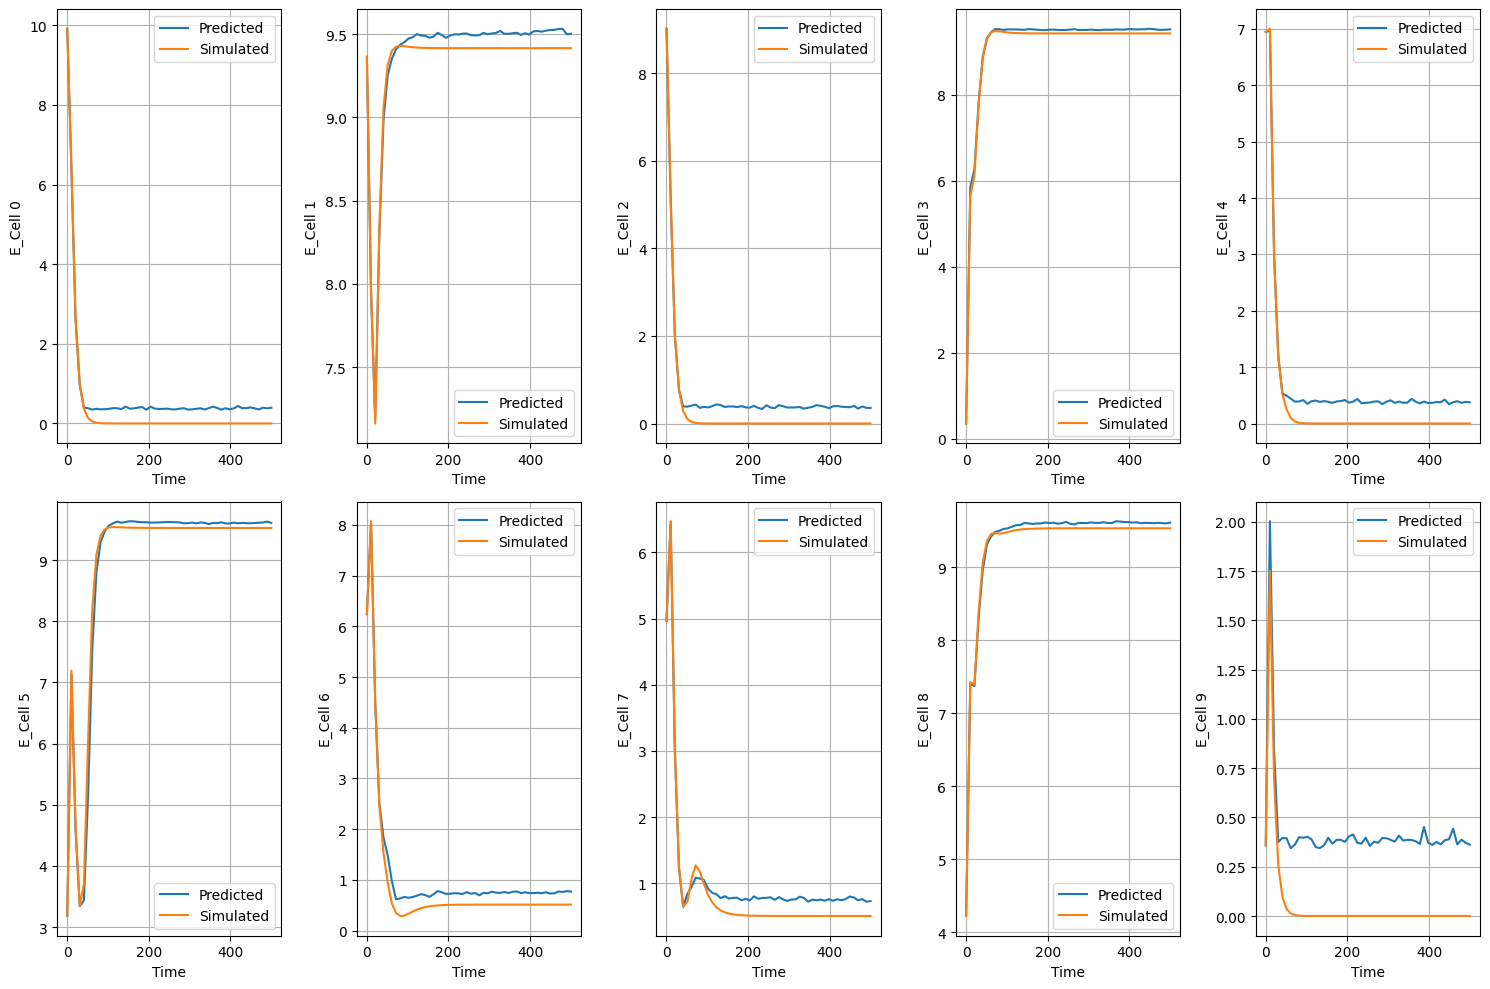

In [32]:
#Plots for E

x1 = np.linspace(0, 50*10)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][4] , label = "Predicted")
    ax[i].plot(x1,sim[i][4], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"E_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

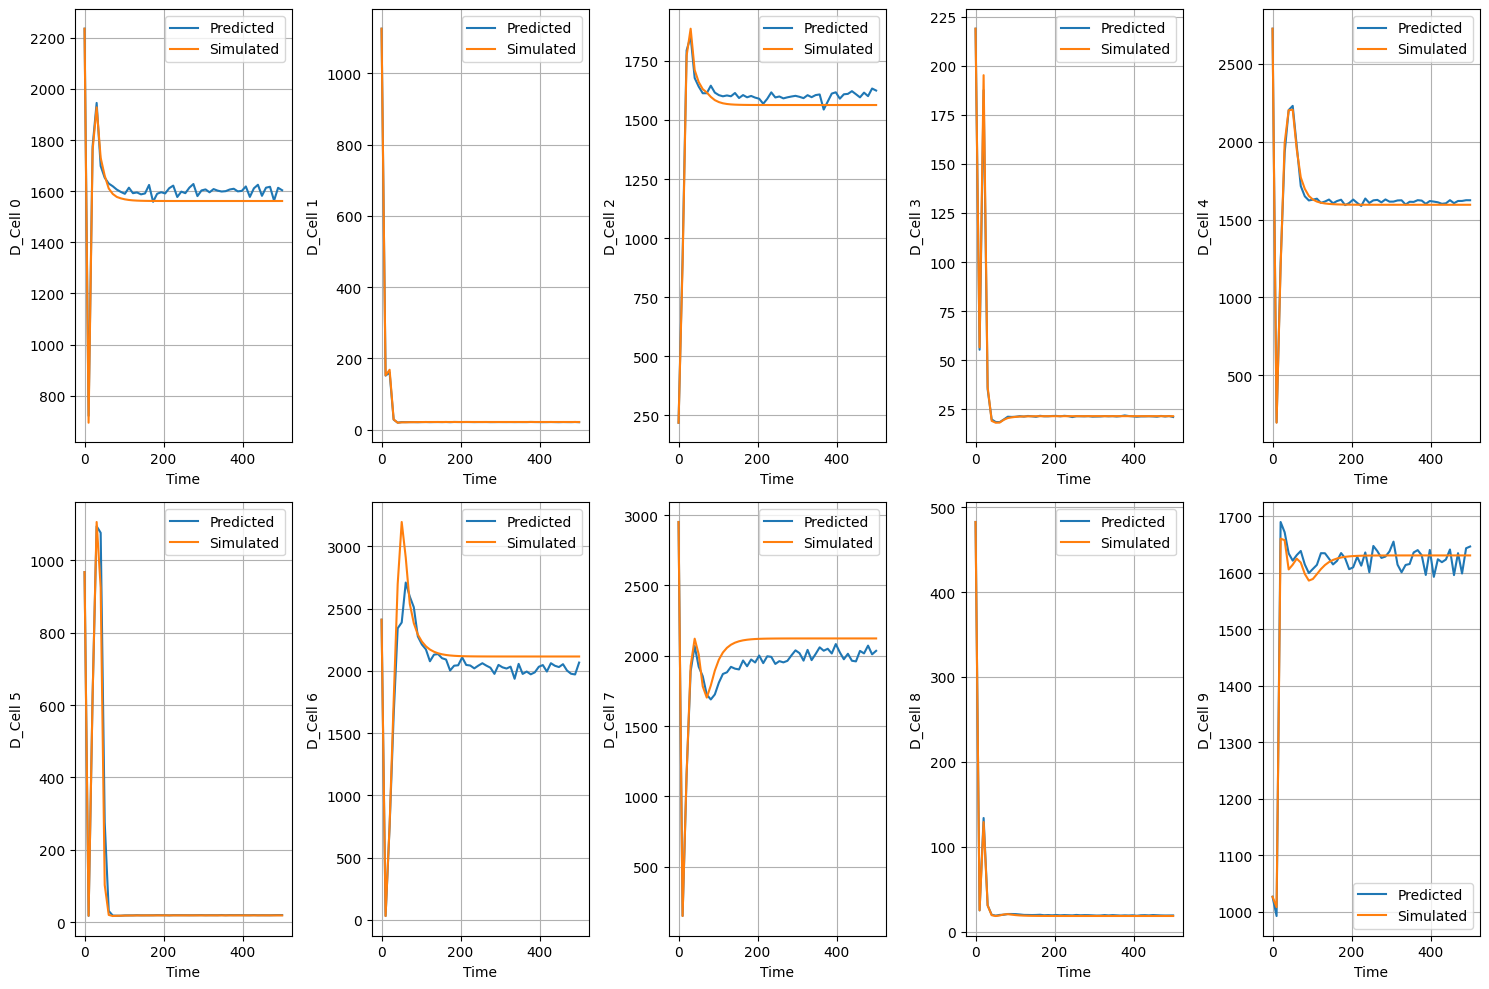

In [33]:
#Plots for D

x1 = np.linspace(0, 50*10)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][5] , label = "Predicted")
    ax[i].plot(x1,sim[i][5], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"D_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

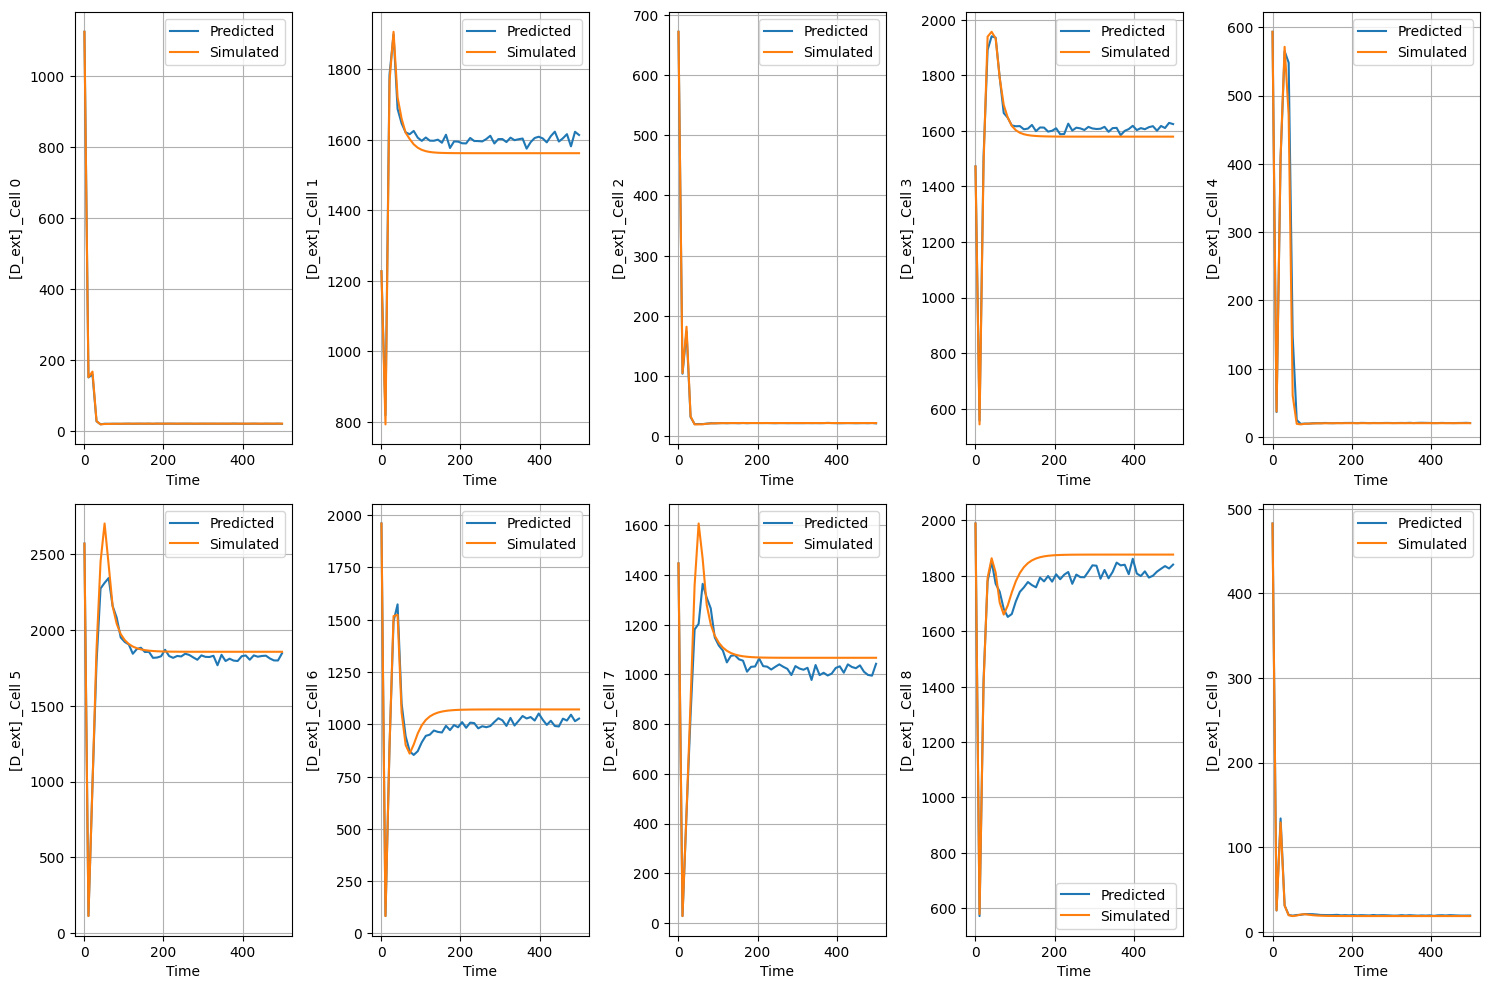

In [34]:
#Plots for D_ext

x1 = np.linspace(0, 50*10)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][1] , label = "Predicted")
    ax[i].plot(x1,sim[i][1] , label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"[D_ext] _Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

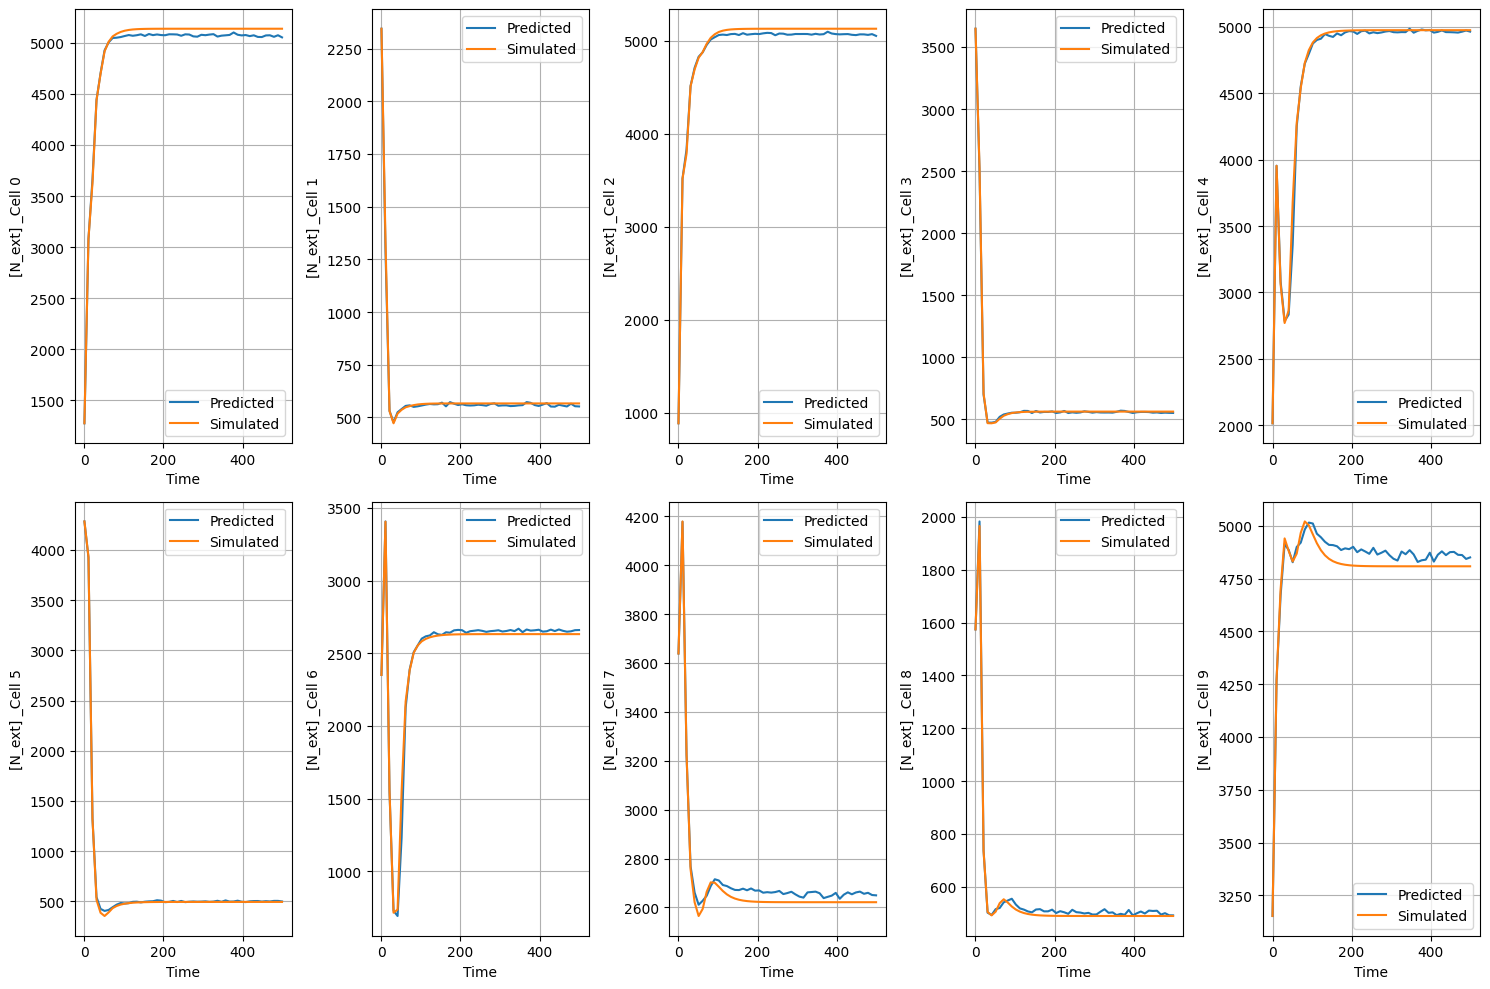

In [35]:
#Plots for N_ext

x1 = np.linspace(0, 50*10)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][0] , label = "Predicted")
    ax[i].plot(x1,sim[i][0] , label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"[N_ext] _Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

# Accuracy and Complexity

In [36]:
# Read dictionary pkl file
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Training_Test_Sets/One_Step_Simulated_Data_Dist_Test.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [38]:
test_dict = {}
test_dict['conditions'] =  tf.convert_to_tensor(
    np.divide(data["Prior"],mX), dtype=float, dtype_hint=None, name=None
    )
test_dict['training'] = 'False'
y_true = data['next_step']

In [ ]:
Accu_Comp = {}
Accu_Comp['T_Exce'] = []
Accu_Comp['Prec'] = []
Accu_Comp['Loss'] = []
for i in range(1,50):
  L = []
  prec = []
  Loss = []
  print(i)
  for p in range(5):
    start = time.time()
    y_pred = amortizer.sample_data(test_dict, n_samples=i, to_numpy = True )
    y_pred = np.squeeze(np.nanmean(y_pred,axis = 1))
    y_pred = np.divide(y_pred,mY)
    end = time.time()
    t = end - start
    L.append(t)
    y_pred = np.nan_to_num(y_pred)
    prec.append(np.mean((abs((abs(y_true)-abs(y_pred))/(y_true))*100)))
    Loss.append(mean_squared_error(y_true, y_pred))

  Accu_Comp['T_Exce'].append(np.mean(L))
  Accu_Comp['Prec'].append(np.mean(prec))
  Accu_Comp['Loss'].append(np.mean(Loss))


In [ ]:
# save dictionary
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Accu_Comp.pkl', 'wb') as fp:
    pickle.dump(Accu_Comp, fp)

In [ ]:
# Read dictionary pkl file
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Accu_Comp.pkl', 'rb') as fp:
    Accu_Comp = pickle.load(fp)

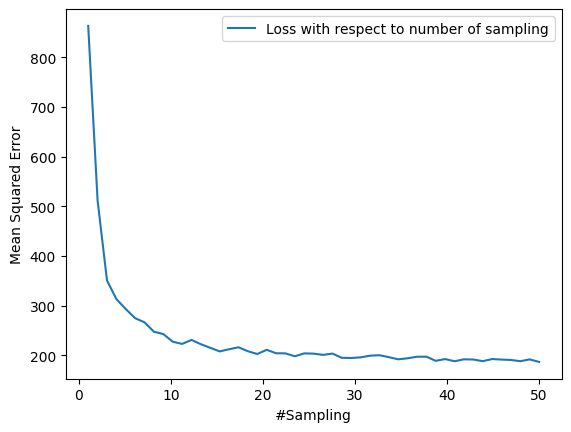

In [40]:
x = np.linspace(1, 50, num = 49)
y1 = Accu_Comp['Loss']
y2 = Accu_Comp['Prec']
y3 = Accu_Comp['T_Exce']
plt.plot(x,y1, label = "Loss with respect to number of sampling")
plt.xlabel("#Sampling")
plt.ylabel("Mean Squared Error")
plt.legend()

In [ ]:
plt.plot(x,y2, label = "Average of Error Percentage with respect to number of sampling")
plt.xlabel("#Sampling")
plt.ylabel("Error")
plt.legend()

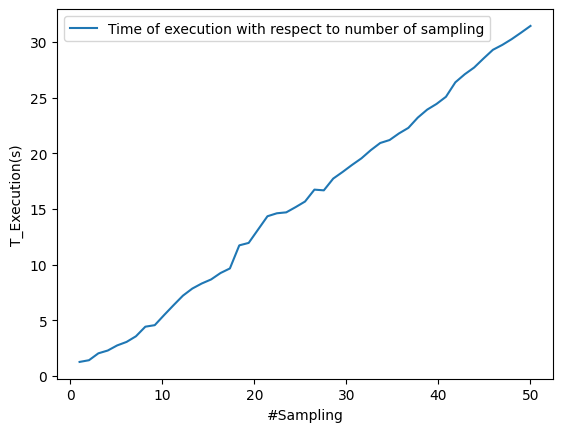

In [42]:
plt.plot(x,y3, label = "Time of execution with respect to number of sampling")
plt.xlabel("#Sampling")
plt.ylabel("T_Execution(s)")
plt.legend()

Histogram for Error

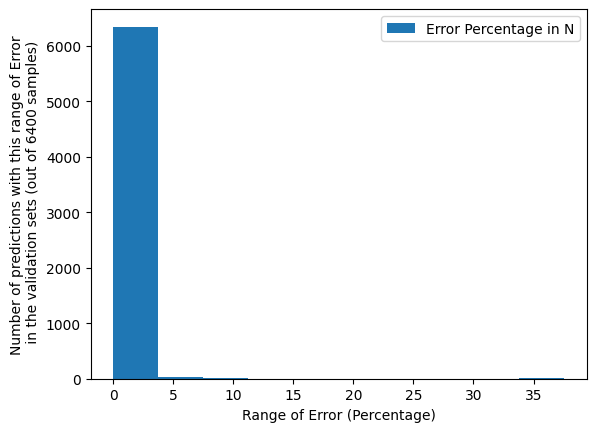

In [47]:
plt.hist((abs((abs(y_true[:,0] )-abs(y_pred[:,0]))/(y_true[:,0]))*100), label = "Error Percentage in N")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 6400 samples)")
plt.xlabel("Range of Error (Percentage)")
plt.legend()

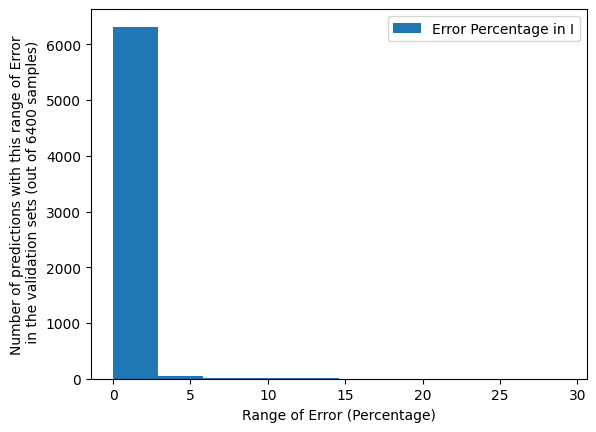

In [48]:
plt.hist((abs((abs(y_true[:,1] )-abs(y_pred[:,1]))/(y_true[:,1]))*100), label = "Error Percentage in I")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 6400 samples)")
plt.xlabel("Range of Error (Percentage)")
plt.legend()

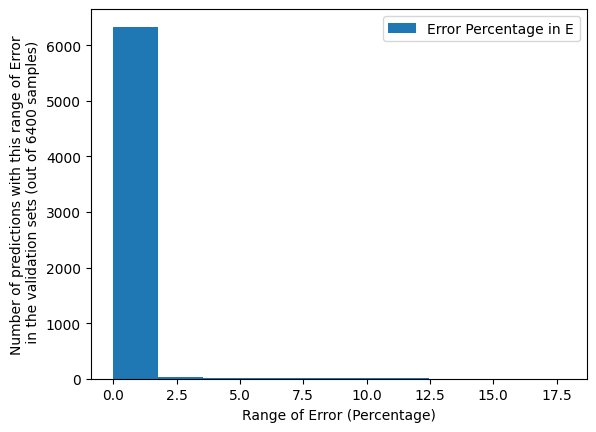

In [49]:
plt.hist((abs((abs(y_true[:,2])-abs(y_pred[:,2]))/(y_true[:,2]))*100), label = "Error Percentage in E")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 6400 samples)")
plt.xlabel("Range of Error (Percentage)")
plt.legend()

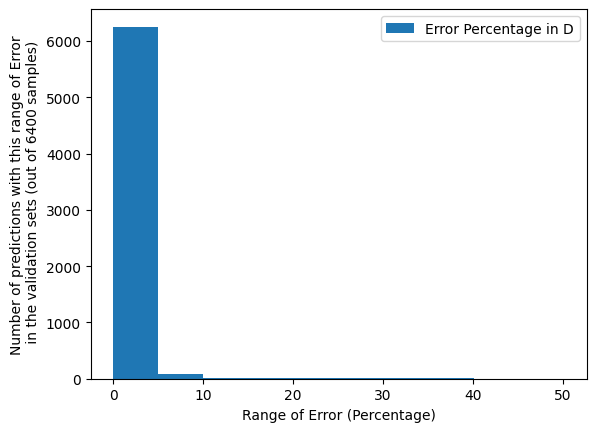

In [50]:
plt.hist((abs((abs(y_true[:,3])-abs(y_pred[:,3]))/(y_true[:,3]))*100), label = "Error Percentage in D")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 6400 samples)")
plt.xlabel("Range of Error (Percentage)")
plt.legend()